# Tutorial of MST-DBSCAN in pysda

In [1]:
import pysda
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches

### Use the build-in functions to read data (highly recommend).

In [2]:
folder = r"D:\pySDA\test_data"

#### Method 1: Load .csv

In [3]:
filename = "DengueKS2014.csv"
path = os.path.join(folder, filename)
crs="+init=epsg:4326"

pysda_data = pysda.data.readCSV(path, xtitle="X", ytitle="Y", ttitle="OnsetDay", crs=crs, tunit="week")

#### Method 2: Load DataFrame

In [4]:
filename = "DengueKS2014.csv"
path = os.path.join(folder, filename)
crs="+init=epsg:4326"
df = pd.read_csv(path, encoding="utf-8")

pysda_data = pysda.data.readDF(df, xtitle="X", ytitle="Y", ttitle="OnsetDay", crs=crs, tunit="week")

#### Method 3: Load .shp

In [5]:
filename = "DengueKS2014.shp"
path = os.path.join(folder, filename)

pysda_data = pysda.data.readSHP(path, ttitle="OnsetDay", tunit="week")

#### Method 4: Load geoDataFrame

In [6]:
filename = "DengueKS2014.shp"
path = os.path.join(folder, filename)
gdf = gpd.read_file(path, encoding="utf-8")

pysda_data = pysda.data.readGDF(gdf, ttitle="OnsetDay", tunit="week")

#### Arguments explanition:
1. **xtitle** is the name of the column which records the x coordinate of each point.
2. **ytitle** is the name of the column which records the y coordinate of each point.  
Note: The values of x and y must be **projected** coordinates rather than longitude and latitude.
3. **crs** is the Coordinate Reference System of the x and y.

4. **ttitle** is the name of the column which records the time of each point either in integer format or in date format. If its values are in integer format, pysda will directly use them as the time stamps; otherwise, pysda will firstly transform them into integer format (through *tunit* argument).

5. **tunit** is the temporal resolution for analysis, and the first time stamp is the first date in the input data. There are several choices:
    - int: assign that the ttitle column in the input data is integer format.
    - hour: 1 hour  
    - day: 1 days
    - week: 7 days
    - month: 30 days
    - year: 365 days
    - tunit also can be any string accepted by pandas' *date_range* function. For more details, please refer to https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases

***
***
### Initialize an instance

In [7]:
mst = pysda.MSTDBSCAN(pysda_data)

### Set parameters 
#### Basic parameters:
- eps_spatial: spatial search radius 
- eps_temporalLow: the minimum value of the temporal search window 
- eps_temporalHigh: the maximum value of the temporal search window
- mis_pts: The minimum number of neughbors for a point to become a *core* and further form a cluster

#### Advanced parameters:
- movingRatio (default is 0.1): 
    This is the threshold value to check whether a cluster's center moves.
    When the distance between centers in two sequential times over the eps_spatial is greater than the value, a cluster is considered as moving its center; otherwise, it stays.
    
- areaRatio (default is 0.1):
    This is the threshold value to check whether a cluster's area changes. 
    When the **absolute** difference of area in two sequential times is greater than the areaRatio, a cluster is considered as changing its area; otherwise, it keeps a similar area.

In [8]:
eps_spatial = 300
eps_temporalLow = 1
eps_temporalHigh = 2
min_pts = 3
movingRatio = 0.1
areaRatio = 0.1

mst.setParams(eps_spatial, eps_temporalLow, eps_temporalHigh, min_pts, movingRatio, areaRatio)

### Start clustering

In [9]:
mst.run()
result = mst.result

core algorithm costs --- 1.9986937046051025 seconds ---


***
***
### Get the result of dynamic clusters
Explaination about the columns:
- **clusterID**: the ID of a cluster.  
    (Note: the value starts from 0, so 0 is the first cluster.)
        
- **mstTime**: a specific time (integer format) when a point is still alive.
- **mstDate**: a specific time (date format) when a point is still alive. 
    
- **type**: the evolution type of a cluster at a specific time.  
    (Note: There are 10 possible types. Please refer to the paper for a detailed description.)
        
- **centerX**, **centerY**: the coordinate of the center of a cluster at a specific time.
    
- **shape**: the polygon of a cluster at a specific time.

In [10]:
clusterGDF = result.clusters
clusterGDF.head(10)

,clusterID,mstTime,type,centerX,centerY,shape,mstDate
0,0,1,Emerge,179695.200767,2.497270e+06,"POLYGON ((179995.200766882 2497269.858528782, ...",2014/05/20-00:00:00
1,0,2,Steady,179695.200767,2.497270e+06,"POLYGON ((179995.200766882 2497269.858528782, ...",2014/05/27-00:00:00
2,1,1,Emerge,179695.200767,2.497270e+06,"POLYGON ((179995.200766882 2497269.858528782, ...",2014/05/20-00:00:00
3,1,2,Steady,179695.200767,2.497270e+06,"POLYGON ((179995.200766882 2497269.858528782, ...",2014/05/27-00:00:00
4,3,3,Emerge,181485.930365,2.496833e+06,"POLYGON ((181720.6486981525 2496999.610708646,...",2014/06/03-00:00:00
5,4,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00
6,5,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00
7,6,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00
8,7,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00
9,8,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00


#### Load a polygon .shp for plotting

In [11]:
filename = "KSVillage.shp"
path = os.path.join(folder, filename)
polygonGDF = gpd.read_file(path, encoding="utf-8")

#### Plot clusters

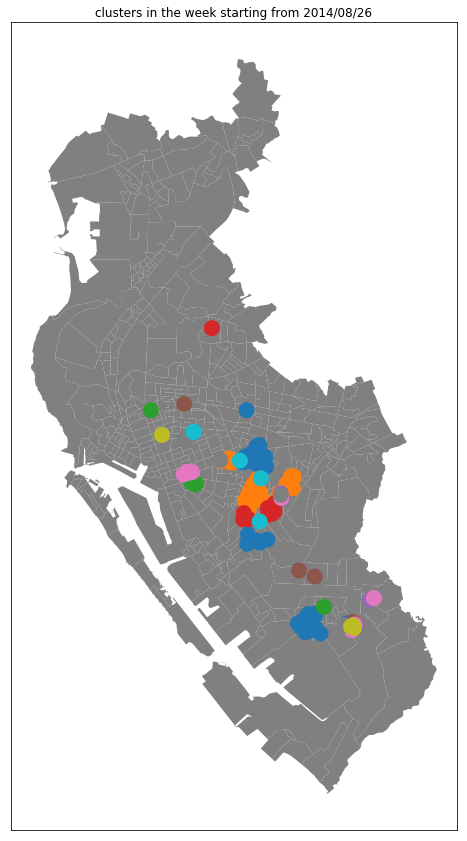

In [14]:
part = clusterGDF[clusterGDF["mstDate"] == '2014/08/26-00:00:00']

fig, ax = plt.subplots(figsize=(8,16))
ax.set_aspect("equal")
ax.set_title("clusters in the week starting from 2014/08/26")
ax.set_xticks([])
ax.set_yticks([])

polygonGDF.plot(ax=ax, color="gray")
part.plot(ax=ax, categorical=True, column="clusterID")

***
***
### Get the result of dynamic points
Explaination about the columns:
- **pointID**: the original ID of a point.
    
- **mstTime**: a specific time (integer format) when a point is still alive.

- **mstDate**: a specific time (date format) when a point is still alive.
    
- **clusterID**: the cluster to which a point belongs at a specific time.  
  (Note: -1 means the point does not belong to any cluster, so its role must be noise.)
        
- **role**: the role (core, border or noise) of a point at a specific time.

In [73]:
pointGDF = result.points
pointGDF.head(10)

,pointID,mstTime,role,clusterID,geometry,index,OnsetDay,GuessDay,InformDay,Gender,...,Number,LiveVill_1,InfectVi_1,Year,Month,Week,FDW,startTime,intTime,mstDate
0,0,0,noise,-1,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/13-00:00:00
1250,0,1,core,0,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/20-00:00:00
1251,0,1,border,0,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/20-00:00:00
1252,0,2,core,0,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/27-00:00:00
1253,0,2,border,0,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/27-00:00:00
1,1,0,noise,-1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/13-00:00:00
1254,1,1,core,1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/20-00:00:00
1255,1,1,border,1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/20-00:00:00
1256,1,2,core,1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/27-00:00:00
1257,1,2,border,1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/27-00:00:00


***
***
### Add polygon data to get the result of further analysis

In [74]:

result.setPolygons(polygonGDF)

### Get the result of polygons
Explaination about the columns:  
- **DZ**: diffusion zones. The polygons that are assigned to the same zone undergo a similar diffusion procedure.

- **The dates**: each date is a mstDate. Each column records the situations (increas, decrease, keep, or no cluster) that every polygons undergo at that time.

    - increase: a polygon is covered by a cluster whose evolution type is Emerge, Growth, Directional growth, or Merge. 
    - decrease: a polygon is covered by a cluster whose evolution type is Reduction, Directional reduction, or Split.
    - keep: a polygon is covered by a cluster whose evolution type is Steady, Move, or SplitMerge.
    - no cluster: a polygon is not covered by any cluster.
            
    
    
    

In [75]:
polygonResultGDF = result.polygons
polygonResultGDF.head(10)

,COUNTY_ID,VILLAGE_ID,VILLAGE,COUNTY,TOWN,V_ID,TOWN_ID,H_CNT,P_CNT,M_CNT,...,2014/06/24-00:00:00,2014/07/01-00:00:00,2014/07/08-00:00:00,2014/07/15-00:00:00,2014/07/22-00:00:00,2014/07/29-00:00:00,2014/08/05-00:00:00,2014/08/12-00:00:00,2014/08/19-00:00:00,2014/08/26-00:00:00
0,64000,066,正仁里,高雄市,苓雅區,64000080-066,64000080,1174.0,3047.0,1464.0,...,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,increase,decrease,decrease,no cluster
1,64000,067,文昌里,高雄市,苓雅區,64000080-067,64000080,1670.0,4474.0,2171.0,...,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,increase,no cluster,no cluster,no cluster
2,64000,068,建軍里,高雄市,苓雅區,64000080-068,64000080,846.0,2361.0,1209.0,...,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,increase,decrease,decrease,no cluster
3,64000,069,衛武里,高雄市,苓雅區,64000080-069,64000080,970.0,2323.0,1177.0,...,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,increase,decrease,decrease,no cluster
4,64000,001,草衙里,高雄市,前鎮區,64000090-001,64000090,4206.0,11042.0,5455.0,...,decrease,keep,no cluster,increase,increase,decrease,increase,decrease,keep,no cluster
5,64000,002,明孝里,高雄市,前鎮區,64000090-002,64000090,1150.0,2807.0,1423.0,...,decrease,keep,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster
6,64000,003,明正里,高雄市,前鎮區,64000090-003,64000090,2558.0,5959.0,3059.0,...,decrease,keep,no cluster,increase,increase,no cluster,increase,no cluster,no cluster,increase
7,64000,004,明義里,高雄市,前鎮區,64000090-004,64000090,1117.0,2694.0,1361.0,...,decrease,keep,no cluster,increase,increase,decrease,increase,decrease,keep,no cluster
8,64000,005,仁愛里,高雄市,前鎮區,64000090-005,64000090,715.0,1527.0,782.0,...,decrease,keep,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster
9,64000,006,德昌里,高雄市,前鎮區,64000090-006,64000090,975.0,2292.0,1142.0,...,decrease,keep,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster


#### ploat diffusion zones

In [ ]:
fig, ax = plt.subplots(figsize=(8,16))
ax.set_aspect("equal")
ax.set_title(column[0:10])
ax.set_xticks([])
ax.set_yticks([])



#### plot polygons' dynamic 

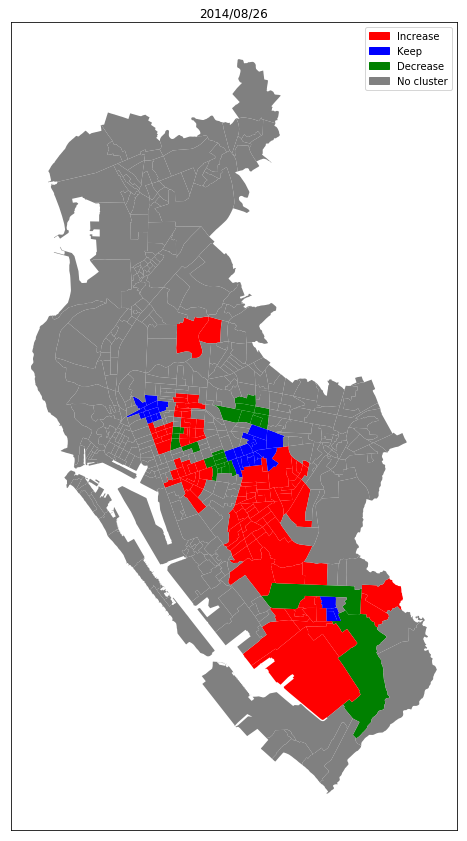

In [78]:

column = '2014/08/26-00:00:00'

fig, ax = plt.subplots(figsize=(8,16))
ax.set_aspect("equal")
ax.set_title(column[0:10])
ax.set_xticks([])
ax.set_yticks([])

increase_patch = mpatches.Patch(color="red", label='Increase')
keep_patch = mpatches.Patch(color="blue", label='Keep')
decrease_patch = mpatches.Patch(color="green", label='Decrease')
non_patch = mpatches.Patch(color="gray", label='No cluster')

ax.legend(handles=[increase_patch, keep_patch, decrease_patch, non_patch])


groupedGDF = polygonResultGDF.groupby(column)
for name, group in groupedGDF:
    if name == "increase":
        group.plot(ax=ax, color="red")
    elif name == "keep":
        group.plot(ax=ax, color="blue")
    elif name == "decrease":
        group.plot(ax=ax, color="green")
    else:
        group.plot(ax=ax, color="gray")

***
***
### Get all results (clusters, points and polygons)

In [79]:
allResults = result.getAll()
clusters = allResults["clusters"]
clusters.head(10)

,clusterID,mstTime,type,centerX,centerY,shape,mstDate
0,0,1,Emerge,179695.200767,2.497270e+06,"POLYGON ((179995.200766882 2497269.858528782, ...",2014/05/20-00:00:00
1,0,2,Steady,179695.200767,2.497270e+06,"POLYGON ((179995.200766882 2497269.858528782, ...",2014/05/27-00:00:00
2,1,1,Emerge,179695.200767,2.497270e+06,"POLYGON ((179995.200766882 2497269.858528782, ...",2014/05/20-00:00:00
3,1,2,Steady,179695.200767,2.497270e+06,"POLYGON ((179995.200766882 2497269.858528782, ...",2014/05/27-00:00:00
4,3,3,Emerge,181485.930365,2.496833e+06,"POLYGON ((181720.6486981525 2496999.610708646,...",2014/06/03-00:00:00
5,4,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00
6,5,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00
7,6,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00
8,7,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00
9,8,5,Split,180034.940433,2.497915e+06,"POLYGON ((180300.45924644 2497908.511059511, 1...",2014/06/17-00:00:00


In [80]:
points = allResults["points"]
points.head(10)

,pointID,mstTime,role,clusterID,geometry,index,OnsetDay,GuessDay,InformDay,Gender,...,Number,LiveVill_1,InfectVi_1,Year,Month,Week,FDW,startTime,intTime,mstDate
0,0,0,noise,-1,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/13-00:00:00
1250,0,1,core,0,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/20-00:00:00
1251,0,1,border,0,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/20-00:00:00
1252,0,2,core,0,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/27-00:00:00
1253,0,2,border,0,POINT (179695.200766882 2497269.858528782),0,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/27-00:00:00
1,1,0,noise,-1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/13-00:00:00
1254,1,1,core,1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/20-00:00:00
1255,1,1,border,1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/20-00:00:00
1256,1,2,core,1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/27-00:00:00
1257,1,2,border,1,POINT (179695.200766882 2497269.858528782),1,2014/05/13,2014/06/06,2014/06/06,男,...,1,6400900-002,6400900-002,2014,5,20,2014/05/12,1,0,2014/05/27-00:00:00


In [81]:
polygons = allResults["polygons"]
polygons.head(10)

,COUNTY_ID,VILLAGE_ID,VILLAGE,COUNTY,TOWN,V_ID,TOWN_ID,H_CNT,P_CNT,M_CNT,...,2014/06/24-00:00:00,2014/07/01-00:00:00,2014/07/08-00:00:00,2014/07/15-00:00:00,2014/07/22-00:00:00,2014/07/29-00:00:00,2014/08/05-00:00:00,2014/08/12-00:00:00,2014/08/19-00:00:00,2014/08/26-00:00:00
0,64000,066,正仁里,高雄市,苓雅區,64000080-066,64000080,1174.0,3047.0,1464.0,...,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,increase,decrease,decrease,no cluster
1,64000,067,文昌里,高雄市,苓雅區,64000080-067,64000080,1670.0,4474.0,2171.0,...,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,increase,no cluster,no cluster,no cluster
2,64000,068,建軍里,高雄市,苓雅區,64000080-068,64000080,846.0,2361.0,1209.0,...,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,increase,decrease,decrease,no cluster
3,64000,069,衛武里,高雄市,苓雅區,64000080-069,64000080,970.0,2323.0,1177.0,...,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,increase,decrease,decrease,no cluster
4,64000,001,草衙里,高雄市,前鎮區,64000090-001,64000090,4206.0,11042.0,5455.0,...,decrease,keep,no cluster,increase,increase,decrease,increase,decrease,keep,no cluster
5,64000,002,明孝里,高雄市,前鎮區,64000090-002,64000090,1150.0,2807.0,1423.0,...,decrease,keep,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster
6,64000,003,明正里,高雄市,前鎮區,64000090-003,64000090,2558.0,5959.0,3059.0,...,decrease,keep,no cluster,increase,increase,no cluster,increase,no cluster,no cluster,increase
7,64000,004,明義里,高雄市,前鎮區,64000090-004,64000090,1117.0,2694.0,1361.0,...,decrease,keep,no cluster,increase,increase,decrease,increase,decrease,keep,no cluster
8,64000,005,仁愛里,高雄市,前鎮區,64000090-005,64000090,715.0,1527.0,782.0,...,decrease,keep,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster
9,64000,006,德昌里,高雄市,前鎮區,64000090-006,64000090,975.0,2292.0,1142.0,...,decrease,keep,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster,no cluster


### Directly save the results to the perfered direction

In [82]:
result.saveAll(folder, prefix="mst_")

### Save the animation of the evolutnio of polygons (.gif)

In [ ]:
result.saveAnimation(figsize=(8,16), dirpath=folder, prefix="mst_")